# Lecture 4: Initialization and Activations

In this lecture, we will discuss the importance of initialization and activation functions in neural networks.

## Complex architectures

In the previous lectures, we have seen how to build a single layer, and a multi-layer neural network. In practice, we often use more complex architectures, such as convolutional neural network (CNN), or a recurrent neural network (RNN).
- MLP: [wikipedia](https://en.wikipedia.org/wiki/Multilayer_perceptron)
- CNN: [LeCun et al. 1989](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf)
- RNN: [Sutskever et al. 2011](https://arxiv.org/pdf/1409.3215)

In order to proceed to those more complex architectures, we need to dive deeper into **activation functions** and **gradients**.

## MLP

Let's continue with our MLP model.

### Importing libraries

In [1]:
import os
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
import numpy as np

def set_seed(seed: int):
    """
    Set the random seed for reproducibility.

    Args:
        seed (int): The seed value to set.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to {seed}")


def configure_device() -> torch.device:
    """
    Configure the device for training.

    Returns:
        torch.device: The device to use for training.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        num_gpu = torch.cuda.device_count()
        print(f"Running on {num_gpu} {torch.cuda.get_device_name()} GPU(s)")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
        print(f"Running on {device}")
    else:
        device = torch.device("cpu")
        print(f"Running on {device}")
    return device


def load_text(file_path: str, encoding: str = 'utf-8') -> str:
    """
    Load and read text data from a file.

    Args:
        file_path (str): Path to the text file.
        encoding (str, optional): File encoding. Defaults to 'utf-8'.

    Returns:
        str: The content of the text file.
    """
    if not os.path.isfile(file_path):
        print(f"File not found: {file_path}")
        raise FileNotFoundError(f"File not found: {file_path}")

    with open(file_path, 'r', encoding=encoding) as f:
        text = f.read()

    print(f"Loaded text data from {file_path} (length: {len(text)} characters).")
    return text
%matplotlib inline

### Configuration

In [2]:
@dataclass
class MLPConfig:
    root_dir: str = os.getcwd() + "/../../"
    dataset_path: str = "data/names.txt"
    device: torch.device = torch.device('cpu')  # Automatic device configuration

    # Tokenizer
    vocab_size: int = 0  # Set later
    
    # Model
    context_size: int = 3
    d_embed: int = 16
    d_hidden: int = 256
    
    # Training
    val_size: float = 0.1
    batch_size: int = 32
    max_steps: int = 1000
    lr: float = 0.01
    val_interval: int = 100

    seed: int = 101

config = MLPConfig()

### Reproducibility

In [3]:
set_seed(config.seed)
generator = torch.Generator().manual_seed(config.seed)

Random seed set to 101


### Device

In [4]:
config.device = configure_device()

Running on 1 NVIDIA GeForce RTX 3060 Ti GPU(s)


### Dataset

In [5]:
# Load text and split by lines
names = load_text(config.root_dir + config.dataset_path).splitlines()

Loaded text data from /mnt/c/Users/danie/NLP/LLM101n/notebooks/Lectures/../../data/names.txt (length: 228145 characters).


### Tokenizer

In [6]:
chars = [chr(i) for i in range(97, 123)]  # all alphabet characters
chars.insert(0, ".")  # Add special token
config.vocab_size = len(chars)
str2idx = {char: idx for idx, char in enumerate(chars)}
idx2str = {idx: char for char, idx in str2idx.items()}

### Preprocessing

#### Train-validation split

In [7]:
def split_names(_names, val_size):
    if val_size <= 0 or val_size >= 1:
        raise ValueError(f"Invalid validation size: {val_size}")
    ################################################################################
    # TODO:                                                                        #
    # Split the data into training and validation sets.                            #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    value_count = int((1-val_size) * len(_names))
    train_text, val_text = _names[:value_count],_names[value_count:]
    
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    return train_text, val_text

In [8]:
train_names, val_names = split_names(names, config.val_size)

#### Dataloader

In [9]:
def prepare_dataset(_names):
    _inputs, _targets = [], []

    for name in _names:
        _context = [0] * config.context_size
        
        for char in name + ".":
            idx = str2idx[char]
            _inputs.append(_context)
            _targets.append(idx)
            _context = _context[1:] + [idx]  # Shift the context by 1 character

    _inputs = torch.tensor(_inputs)
    _targets = torch.tensor(_targets)
    
    return _inputs, _targets

In [10]:
train_inputs, train_targets = prepare_dataset(train_names)
val_inputs, val_targets = prepare_dataset(val_names)

In [11]:
# Check the shapes
print(f"Training (Inputs, Targets) shapes: ({train_inputs.shape}, {train_targets.shape})")
print(f"Validation (Inputs, Targets) shapes: ({val_inputs.shape}, {val_targets.shape})")
# Example input and target pairs
print(f"First Train (Input, target): ({train_inputs[0]}, {train_targets[0]})")
print(f"First Validation (Input, Target): ({val_inputs[0]}, {val_targets[0]})")
print(f"Second Train (Input, Target): ({train_inputs[1]}, {train_targets[1]})")
print(f"Second Validation (Input, Target): ({val_inputs[1]}, {val_targets[1]})")

Training (Inputs, Targets) shapes: (torch.Size([205411, 3]), torch.Size([205411]))
Validation (Inputs, Targets) shapes: (torch.Size([22735, 3]), torch.Size([22735]))
First Train (Input, target): (tensor([0, 0, 0]), 5)
First Validation (Input, Target): (tensor([0, 0, 0]), 1)
Second Train (Input, Target): (tensor([0, 0, 5]), 13)
Second Validation (Input, Target): (tensor([0, 0, 1]), 18)


### Model

In [12]:
class MLP(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.b1 = nn.Parameter(torch.randn(d_hidden))
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size))
        self.b2 = nn.Parameter(torch.randn(vocab_size))
        
    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)
        
        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)
        
        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [13]:
# Initialize the model
mlp = MLP(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlp.to(config.device) # Move the model to the device
print(mlp)
print("Number of parameters:", sum(p.numel() for p in mlp.parameters()))

MLP()
Number of parameters: 19915


### Training

In [14]:
def train(model):
    steps = []
    train_losses = []
    val_losses = []

    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=config.lr)

    for step in range(1, config.max_steps + 1):
        # Training
        model.train()  # Set the model to training mode
        # Mini-batch
        idx = torch.randperm(len(train_inputs))[:config.batch_size]
        x, y = train_inputs[idx], train_targets[idx]
        x, y = x.to(config.device), y.to(config.device)  # Move the data to the device

        ################################################################################
        # TODO:                                                                        #
        # Implement the forward pass and the backward pass                             #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # Forward pass
        optimizer.zero_grad()
        logits = model(x)
        # print(logits[0])
        loss = F.cross_entropy(logits,y)

        # Backward pass
        loss.backward()
        optimizer.step()
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        steps.append(step)
        train_losses.append(loss.item())

        # Validation
        if step % config.val_interval == 0:
            model.eval()  # Set the model to evaluation mode
            with torch.no_grad():
                val_logits = model(val_inputs.to(config.device))
                val_loss = F.cross_entropy(val_logits, val_targets.to(config.device)).item()
                val_losses.append(val_loss)
            print(f"Step {step}: Train Loss = {loss.item():.4f}, Val Loss = {val_loss:.4f}")

        if step == 1:
            print(f"Initial Train Loss = {loss.item():.4f}")

    # Plot the loss
    plt.figure()
    plt.plot(steps, train_losses, label="Train")
    val_steps = [step for step in steps if step % config.val_interval == 0]
    plt.plot(val_steps, val_losses, label="Validation")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Initial Train Loss = 28.5504
Step 100: Train Loss = 20.2255, Val Loss = 20.8738
Step 200: Train Loss = 15.6984, Val Loss = 17.8466
Step 300: Train Loss = 13.8724, Val Loss = 15.8413
Step 400: Train Loss = 14.0680, Val Loss = 14.5659
Step 500: Train Loss = 11.7364, Val Loss = 13.6573
Step 600: Train Loss = 10.4651, Val Loss = 12.9011
Step 700: Train Loss = 13.3025, Val Loss = 12.2659
Step 800: Train Loss = 10.0486, Val Loss = 11.7036
Step 900: Train Loss = 7.5713, Val Loss = 11.2719
Step 1000: Train Loss = 7.6111, Val Loss = 10.8837


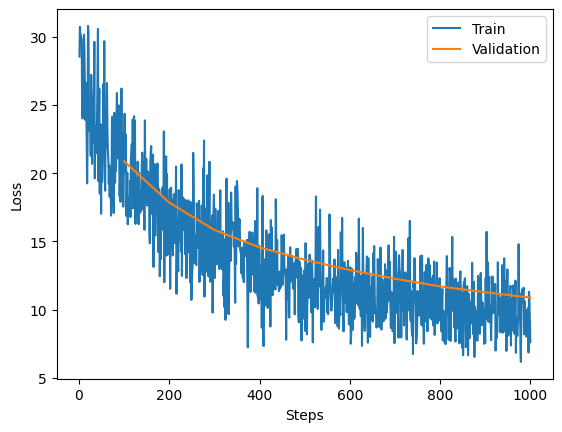

In [15]:
train(mlp)

#### Problem 1: Initialization

Q: What is the initial loss value? What can you discuss about the loss value?

In [17]:
################################################################################
# TODO:                                                                        #
# Before the model is trained,                                                 #
# we expect the model to predict a uniform distribution over the classes       #
# What should be the initial loss value for a uniform distribution?            #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
prob = 1/27
initial_loss = -torch.log(torch.tensor(prob)).item()
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
print(f"Initial loss value: {initial_loss:.4f}")

Initial loss value: 3.2958


In [21]:
# Example of wrong initialization issue
# Goal: Predict the correct class out of 4 classes
#example_logits = torch.tensor([0, 0, 0, 0], dtype=torch.float32)  # Uniform distribution
exemple_logits = (torch.randn(4)+1) * 1000
target = 0
prob = F.softmax(exemple_logits, dim=-1)
loss = -prob[target].log()

print(f"Example logits: {exemple_logits}")
print(f"Example probabilities: {prob}")
print(f"Example loss value: {loss:.4f}")

# logits의 값이 너무 크면 한 클래스의 확률이 거의 1에 가까워 질 수 있음 (소프트맥스는 exponential)

Example logits: tensor([ 864.5471, 1117.4160, 1707.1006, 2600.9968])
Example probabilities: tensor([0., 0., 0., 1.])
Example loss value: inf


In [40]:
# Solution: Re-initialize the model
# Make the logits smaller
class MLP2(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed))
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden))
        self.b1 = nn.Parameter(torch.randn(d_hidden))
        ################################################################################
        # TODO:                                                                        #
        # Re-initialize the model with a small value to get low logits                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size)*0.1)
        self.b2 = nn.Parameter(torch.randn(vocab_size)*0.01)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)
        
        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)
        
        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [41]:
# Initialize the MLP V2
mlp2 = MLP2(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlp2.to(config.device) # Move the model to the device
print(mlp2)
print("Number of parameters:", sum(p.numel() for p in mlp2.parameters()))

MLP2()
Number of parameters: 19915


Initial Train Loss = 3.9966
Step 100: Train Loss = 3.1752, Val Loss = 3.3402
Step 200: Train Loss = 3.1486, Val Loss = 3.1469
Step 300: Train Loss = 2.7097, Val Loss = 3.0362
Step 400: Train Loss = 2.8437, Val Loss = 2.9600
Step 500: Train Loss = 2.9780, Val Loss = 2.9116
Step 600: Train Loss = 2.5149, Val Loss = 2.8706
Step 700: Train Loss = 2.5060, Val Loss = 2.8431
Step 800: Train Loss = 2.6053, Val Loss = 2.8129
Step 900: Train Loss = 2.0846, Val Loss = 2.8038
Step 1000: Train Loss = 2.8008, Val Loss = 2.7760


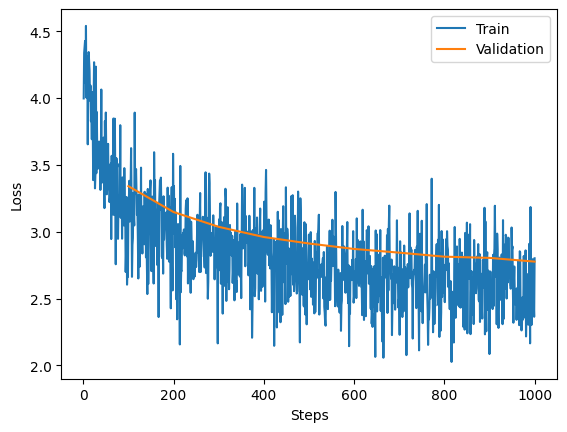

In [42]:
# Train the model
# train(model=mlp2, max_steps=1)
train(mlp2)

Initialization problem solved!

Remember, initialization is a crucial step in training neural networks. If the weights are initialized with large values, the model may not converge. 

#### Problem 2: Activation functions

Q: What is the activation function used in the hidden layer? What is the 
characteristic of this activation function?

[PyTorch Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)

In [43]:
# Forward pass
_idx = torch.randperm(len(train_inputs))[:config.batch_size]
_x = train_inputs[_idx]
_x_embed = mlp2.C[_x]
_x = _x_embed.view(_x.size(0), -1)
_x = _x @ mlp2.W1 + mlp2.b1
h = F.tanh(_x)

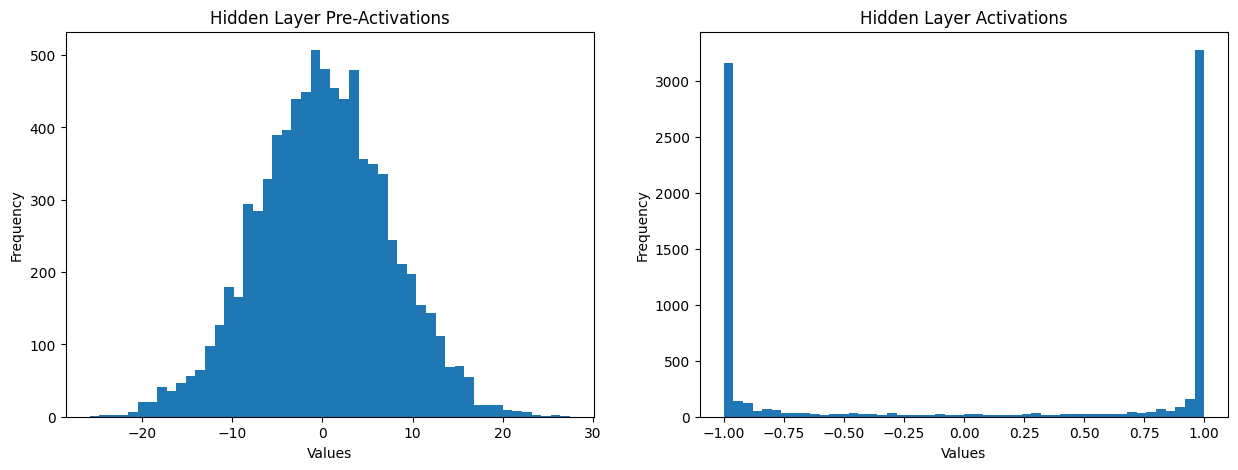

In [44]:
# Plot the histogram of the hidden layer pre-activations and activations
plt.figure(figsize=(15, 5))
# Pre-activations
plt.subplot(1, 2, 1)
plt.hist(_x.view(-1).tolist(), bins=50)
plt.title("Hidden Layer Pre-Activations")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Activations
plt.subplot(1, 2, 2)
plt.hist(h.view(-1).tolist(), bins=50, range=(-1, 1))
plt.title("Hidden Layer Activations")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

In [45]:
plt.figure(figsize=(20, 10))
# White if the value is larger than 0.99
# Black if the value is smaller than 0.99
plt.imshow(h.abs().cpu().detach().numpy() > 0.99, cmap="gray", interpolation="nearest")
# If there is a column with all white, it means that the model will never learn -> Dead Neurons

In [46]:
################################################################################
# TODO:                                                                        #
# Explain the problem with the graph above.                                    #
# Hint: Lecture 1, custom tensor auto-grad engine.                             #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
''' A Dead neuron has zero gradient, which means its weights won't be updated. '''
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

" A Dead neuron has zero gradient, which means its weights won't be updated. "

Adding more layers and making the model deeper is known to have better generalization performance.

The reason why people didn't add more layers in the past was because of the vanishing gradient problem.

In [47]:
# Solution1: Re-re-initialize the model
# Make the pre-activations smaller
class MLP3(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Re-initialize the model with a small value                                   #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed) * 0.1)                # Initialize with a small value
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden) * 0.2)  # Initialize with a small value
        self.b1 = nn.Parameter(torch.randn(d_hidden) * 0.1)                          # Initialize with a small value
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size) * 0.1)              # Initialize with a small value
        self.b2 = nn.Parameter(torch.randn(vocab_size) * 0.01)  
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        
    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)
        
        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)
        
        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [48]:
# Initialize the MLP V3
mlp3 = MLP3(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlp3.to(config.device) # Move the model to the device
print(mlp3)
print("Number of parameters:", sum(p.numel() for p in mlp3.parameters()))

MLP3()
Number of parameters: 19915


In [49]:
# Forward pass
_idx = torch.randperm(len(train_inputs))[:config.batch_size]
_x = train_inputs[_idx]
_x_embed = mlp3.C[_x]
_x = _x_embed.view(_x.size(0), -1)
_x = _x @ mlp3.W1 + mlp3.b1
h = F.tanh(_x)

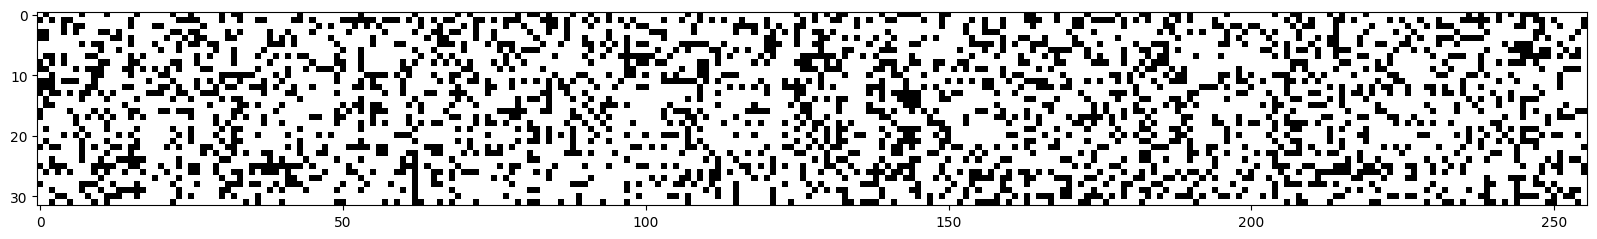

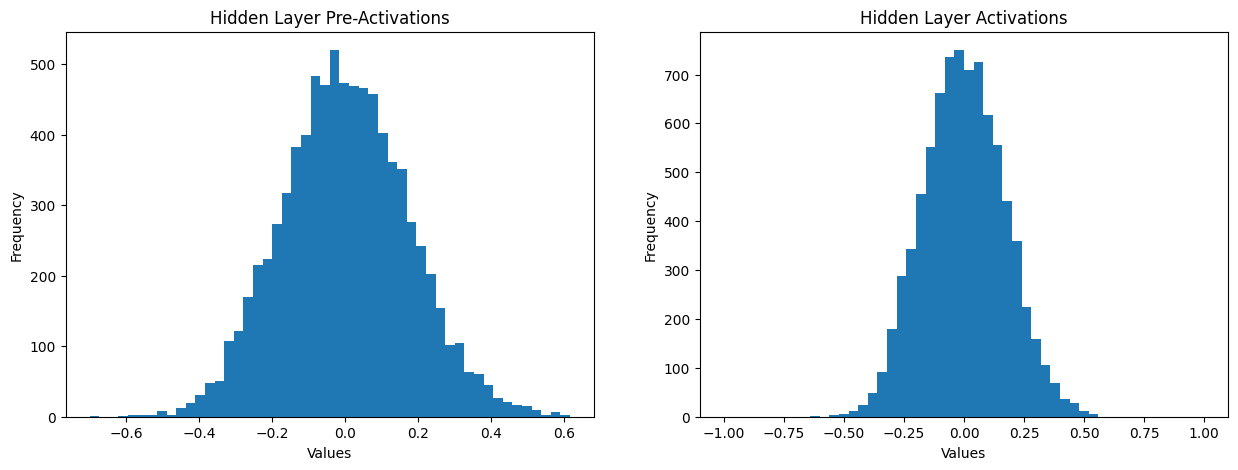

In [50]:
# Plot the histogram of the hidden layer pre-activations and activations
plt.figure(figsize=(15, 5))
# Pre-activations
plt.subplot(1, 2, 1)
plt.hist(_x.view(-1).tolist(), bins=50)
plt.title("Hidden Layer Pre-Activations")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Activations
plt.subplot(1, 2, 2)
plt.hist(h.view(-1).tolist(), bins=50, range=(-1, 1))
plt.title("Hidden Layer Activations")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

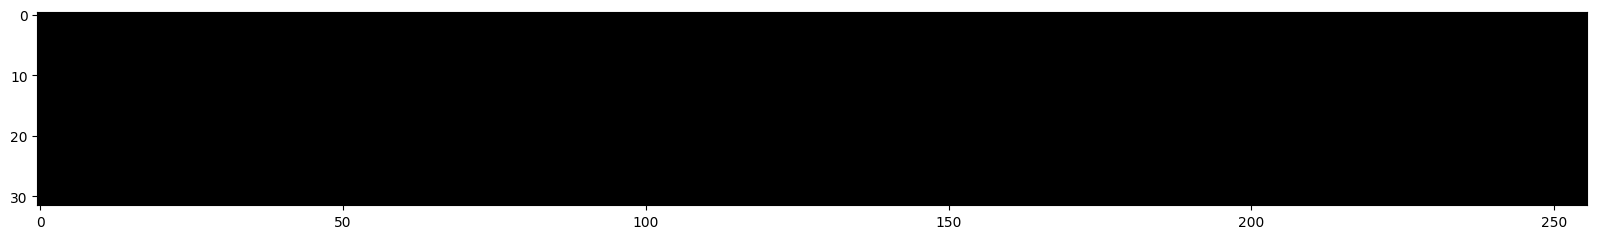

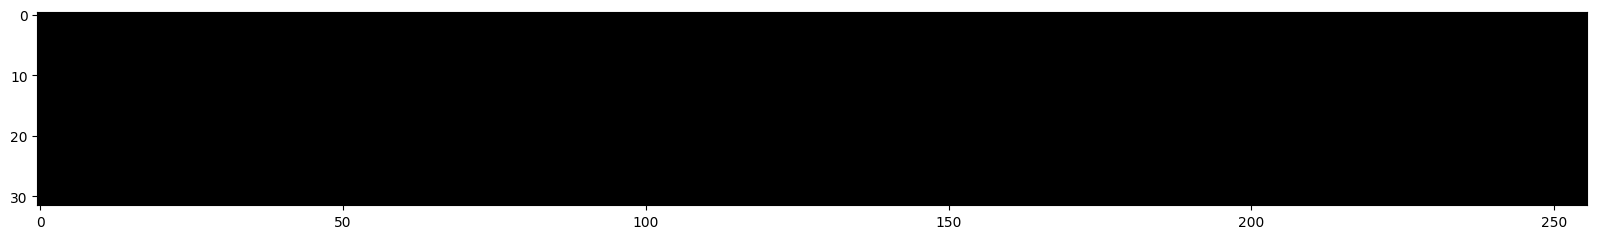

<Figure size 2000x1000 with 0 Axes>

In [55]:
plt.figure(figsize=(20, 10))
# White if the value is larger than 0.99
# Black if the value is smaller than 0.99
plt.show()
plt.imshow(h.abs().cpu().detach().numpy() > 0.99, cmap="gray", interpolation="nearest")
# If there is a column with all white, it means that the model will never learn -> Dead Neurons

Initial Train Loss = 3.3795
Step 100: Train Loss = 3.0595, Val Loss = 3.1261
Step 200: Train Loss = 2.9506, Val Loss = 2.9944
Step 300: Train Loss = 2.8296, Val Loss = 2.9151
Step 400: Train Loss = 2.8538, Val Loss = 2.8603
Step 500: Train Loss = 2.6530, Val Loss = 2.8166
Step 600: Train Loss = 2.2854, Val Loss = 2.7821
Step 700: Train Loss = 2.5932, Val Loss = 2.7571
Step 800: Train Loss = 2.4460, Val Loss = 2.7376
Step 900: Train Loss = 2.7577, Val Loss = 2.7203
Step 1000: Train Loss = 2.4080, Val Loss = 2.7056


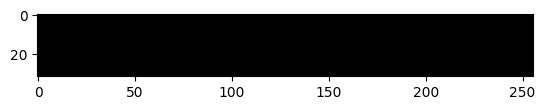

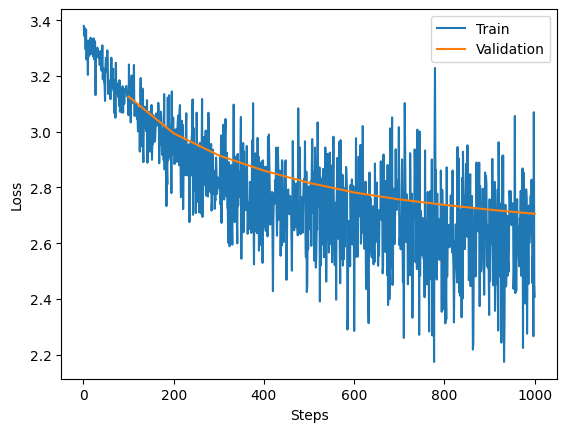

In [56]:
# Train the model
train(mlp3)

**Summary**

1. Raw model           -> Val Loss = 10.8837
2. Initialization fix  -> Val Loss = 2.7808
3. Saturation fix      -> Val Loss = 2.7467

There was an improvement even in this simple model. Imagine the effect of these problems in a deeper model.

#### Solution: Kaiming Initialization

What should be the scale of the weights when initializing the model? (We can't try all the values every time)

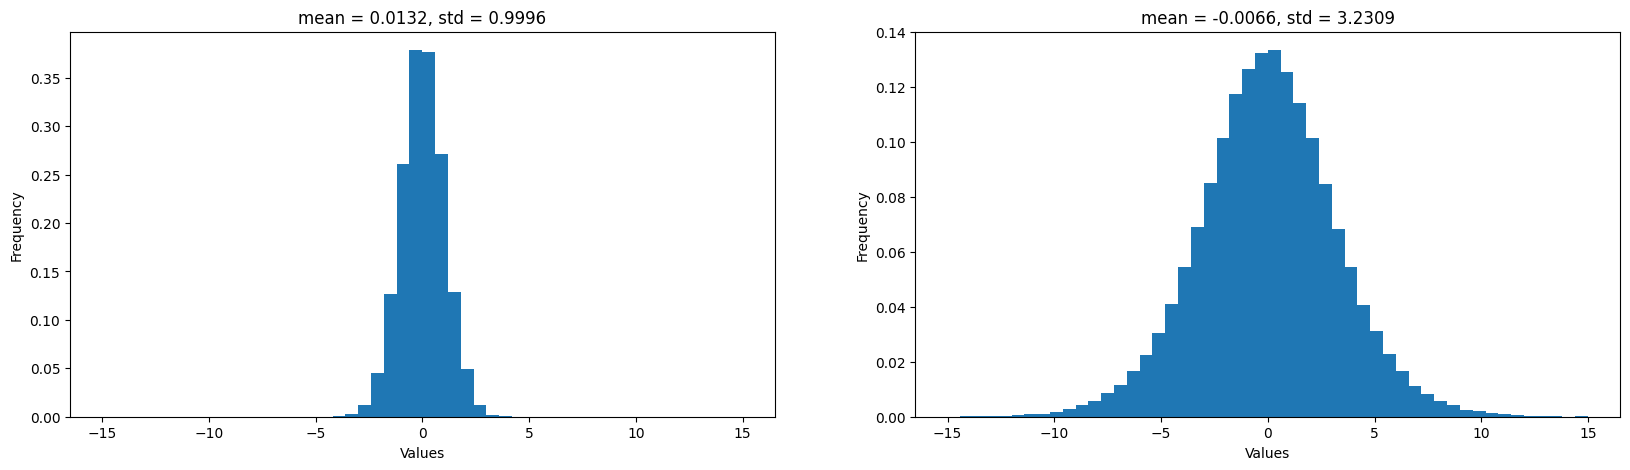

In [57]:
# Example distribution
x = torch.randn(1000, 10)  # 1000 samples, 10 features
W = torch.randn(10, 200)   # 10 features, 200 hidden units
y = x @ W

# Plot the histogram of the output distribution
plt.figure(figsize=(20, 5))
# Input
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50, density=True, range=(-15, 15))
plt.title(f"mean = {x.mean().item():.4f}, std = {x.std().item():.4f}")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Output
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50, density=True, range=(-15, 15))
plt.title(f"mean = {y.mean().item():.4f}, std = {y.std().item():.4f}")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

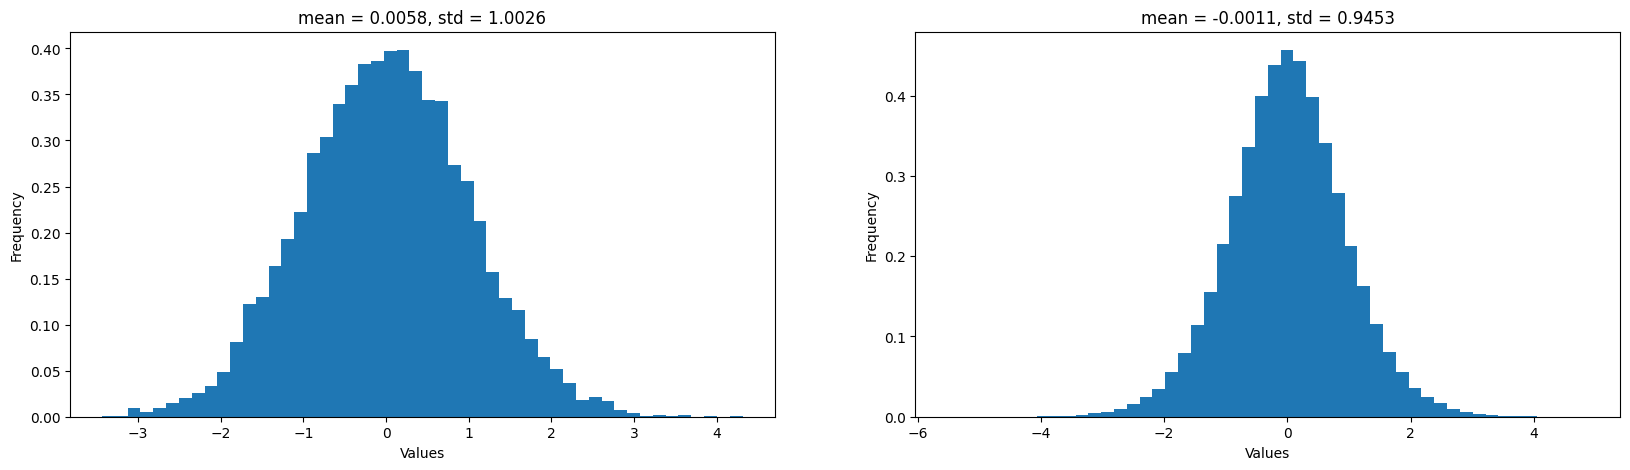

In [61]:
################################################################################
# TODO:                                                                        #
# We want the same distribution for every layer (mean=1, std=1)                #
# The gaussian distribution expanded from std=1 to std=3                       #
# What should be the scale of the weights in the example above?                #
################################################################################
x = torch.randn(1000, 10)
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
scale = 0.3
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
W = torch.randn(10, 200) * scale
y = x @ W

# Plot the histogram of the output distribution
plt.figure(figsize=(20, 5))
# Input
plt.subplot(1, 2, 1)
plt.hist(x.view(-1).tolist(), bins=50, density=True)
plt.title(f"mean = {x.mean().item():.4f}, std = {x.std().item():.4f}")
plt.xlabel("Values")
plt.ylabel("Frequency")
# Output
plt.subplot(1, 2, 2)
plt.hist(y.view(-1).tolist(), bins=50, density=True)
plt.title(f"mean = {y.mean().item():.4f}, std = {y.std().item():.4f}")
plt.xlabel("Values")
plt.ylabel("Frequency")
plt.show()

Number of papers looked into this initialization problem: making the weights not shrink or explode.

One of the most popular solutions is the Kaiming Initialization. [He et al. 2015](https://arxiv.org/pdf/1502.01852)

PyTorch has a built-in function for Kaiming initialization. [PyTorch Documentation](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

**scale = gain / sqrt(fan_in)**
- gain

![gain](../../assets/gain.png)

- fan_in: number of input units

In [ ]:
# Final solution: Re-re-re-initialize the model
# Kaiming Initialization
class MLP4(nn.Module):
    def __init__(self, vocab_size, context_size, d_embed, d_hidden):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Re-initialize the model with Kaiming Initialization                           #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.linear_gain = 1
        self.tanh_gain = 5.0/3.0
        self.embedding_scale = self.linear_gain/()
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.C = nn.Parameter(torch.randn(vocab_size, d_embed) * self.embedding_scale)
        self.W1 = nn.Parameter(torch.randn(context_size * d_embed, d_hidden) * self.hidden_scale)
        self.b1 = nn.Parameter(torch.randn(d_hidden) * 0.1)
        self.W2 = nn.Parameter(torch.randn(d_hidden, vocab_size) * self.output_scale)
        self.b2 = nn.Parameter(torch.randn(vocab_size) * 0.01)
        
    def forward(self, x):  # x: (batch_size, context_size)
        # Embedding
        x_embed = self.C[x]  # (batch_size, context_size, d_embed)
        x = x_embed.view(x.size(0), -1)  # (batch_size, context_size * d_embed)
        
        # Hidden layer
        h = F.tanh(x @ self.W1 + self.b1)  # (batch_size, d_hidden)
        
        # Output layer
        logits = torch.matmul(h, self.W2) + self.b2  # (batch_size, vocab_size)
        return logits

In [ ]:
# Initialize the MLP V4
mlp4 = MLP4(config.vocab_size, config.context_size, config.d_embed, config.d_hidden)
mlp4.to(config.device) # Move the model to the device
print(mlp4)
print("Number of parameters:", sum(p.numel() for p in mlp4.parameters()))

In [ ]:
# Train the model
train(mlp4)

Final val loss: 2.7497 Yay!